In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d  kmader/skin-cancer-mnist-ham10000
!unzip  skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

**MERGING DATASET**

In [ ]:
import os
import shutil

# Define source folders
source_folder_1 = '/content/HAM10000_images_part_1'
source_folder_2 = '/content/HAM10000_images_part_2'
# Define destination folder
destination_folder = "/content/HAM10000_merged"

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Copy all images from both folders into the merged directory
for folder in [source_folder_1, source_folder_2]:
    for file_name in os.listdir(folder):
        source_path = os.path.join(folder, file_name)
        dest_path = os.path.join(destination_folder, file_name)
        shutil.copy(source_path, dest_path)

#print(f"✅ Merged dataset contains {len(os.listdir(destination_folder))} images.")


In [ ]:
merged_path = '/content/HAM10000_merged'
print("Total images in HAM10000_merged:", len(os.listdir(merged_path)))


Total images in HAM10000_merged: 10015


**Splitting into 7 classes using metadata.csv and also splitting into traina nd test further**

In [ ]:
import pandas as pd
import os
import shutil

# Paths
dataset_path = "/content/HAM10000_merged"
train_path = "/content/HAM10000/train"
test_path = "/content/HAM10000/test"
csv_path = "/content/HAM10000_metadata.csv"  # Metadata file

# Read CSV file
df = pd.read_csv(csv_path)

# Ensure train/test folders exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Get unique class labels
labels = df["dx"].unique()

# Create class folders inside train/test
for label in labels:
    os.makedirs(os.path.join(train_path, label), exist_ok=True)
    os.makedirs(os.path.join(test_path, label), exist_ok=True)

# Split data into 80% train and 20% test
train_ratio = 0.8
train_files = set(df.sample(frac=train_ratio, random_state=42)["image_id"] + ".jpg")
test_files = set(df["image_id"] + ".jpg") - train_files

# Copy images into respective class folders
for _, row in df.iterrows():
    img_name = row["image_id"] + ".jpg"
    label = row["dx"]  # Class label

    src_path = os.path.join(dataset_path, img_name)

    # Choose destination folder
    if img_name in train_files:
        dest_folder = os.path.join(train_path, label)
    else:
        dest_folder = os.path.join(test_path, label)

    dest_path = os.path.join(dest_folder, img_name)

    # Copy the image safely
    if os.path.exists(src_path):
        shutil.copy(src_path, dest_path)
    else:
        print(f"⚠️ Missing file: {img_name}")

print("✅ Images successfully sorted into train/test sets.")


✅ Images successfully sorted into train/test sets.


In [ ]:
train_path = "/content/HAM10000/train"
test_path = "/content/HAM10000/test"

print("Total train images:", sum(len(files) for _, _, files in os.walk(train_path)))
print("Total test images:", sum(len(files) for _, _, files in os.walk(test_path)))


Total train images: 8012
Total test images: 2003


In [ ]:
#deleting merged folder
import shutil
shutil.rmtree(dataset_path)
print("✅ Merged folder deleted. Images are now safely in train/test folders.")


✅ Merged folder deleted. Images are now safely in train/test folders.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers,models

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
training_gen=ImageDataGenerator(rescale=1/255,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True)
training_set=training_gen.flow_from_directory('/content/HAM10000/train',
                                              target_size=(64,64),
                                              batch_size=32,
                                              class_mode='categorical')

Found 8012 images belonging to 7 classes.


In [ ]:
test_gen=ImageDataGenerator(rescale=1/255)

In [ ]:
test_set=test_gen.flow_from_directory('/content/HAM10000/test',
                  target_size=(64,64),
                  batch_size=32,
                  class_mode='categorical')

Found 2003 images belonging to 7 classes.


In [ ]:
cnn=models.Sequential([layers.Conv2D(filters=32,kernel_size=3,padding='same',input_shape=(64,64,3)),
                       layers.BatchNormalization(),
                       layers.LeakyReLU(),
                       layers.MaxPool2D(pool_size=2,strides=2),
                       layers.Conv2D(filters=64,kernel_size=3,padding='same'),
                       layers.BatchNormalization(),
                       layers.LeakyReLU(),
                       layers.MaxPool2D(pool_size=2,strides=2),
                       layers.Conv2D(filters=128,kernel_size=3,padding='same'),
                       layers.BatchNormalization(),
                       layers.LeakyReLU(),
                       layers.MaxPool2D(pool_size=2,strides=2),
                       layers.Flatten(),
                       layers.Dense(128),
                       layers.LeakyReLU(),
                       layers.Dropout(0.2),
                       layers.Dense(64),
                       layers.Dropout(0.2),
                       layers.LeakyReLU(),
                       layers.Dense(32),
                       layers.LeakyReLU(),
                       ])
cnn.add(layers.Dense(7,activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#import tensorflow as tf

#checkpoint_path = "Deepfake.keras"
#checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                         save_weights_only=False,
#                                                         save_best_only=False,
#                                                        verbose=1)


In [ ]:
cnn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,0

 Total params: 1,153,415 (4.40 MB)

 Trainable params: 1,152,967 (4.40 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
cnn.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model = cnn.fit(x=training_set,validation_data=test_set,epochs=25)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 101s 365ms/step - accuracy: 0.6183 - loss: 1.3841 - val_accuracy: 0.1408 - val_loss: 1.7772
Epoch 2/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 80s 319ms/step - accuracy: 0.6767 - loss: 0.9105 - val_accuracy: 0.6695 - val_loss: 0.8700
Epoch 3/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 70s 279ms/step - accuracy: 0.7068 - loss: 0.8074 - val_accuracy: 0.6665 - val_loss: 0.9448
Epoch 4/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 69s 277ms/step - accuracy: 0.7154 - loss: 0.7965 - val_accuracy: 0.7219 - val_loss: 0.7825
Epoch 5/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 72s 284ms/step - accuracy: 0.7280 - loss: 0.7698 - val_accuracy: 0.7009 - val_loss: 0.7665
Epoch 6/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 70s 279ms/step - accuracy: 0.7313 - loss: 0.7461 - val_accuracy: 0.5492 - val_loss: 1.2891
Epoch 7/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 71s 284ms/step - accuracy: 0.7340 - loss: 0.7406 - val_accuracy: 0.6790 - val_loss: 0.9316
Epoch 8/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 72s 288ms/step - accuracy: 0.7412 - loss: 

In [ ]:
model = cnn.fit(x=training_set,validation_data=test_set,epochs=25)

Epoch 1/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 81s 324ms/step - accuracy: 0.7908 - loss: 0.5394 - val_accuracy: 0.7264 - val_loss: 0.7910
Epoch 2/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 80s 317ms/step - accuracy: 0.7966 - loss: 0.5349 - val_accuracy: 0.7599 - val_loss: 0.6593
Epoch 3/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 80s 320ms/step - accuracy: 0.7960 - loss: 0.5377 - val_accuracy: 0.7728 - val_loss: 0.6550
Epoch 4/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 70s 279ms/step - accuracy: 0.8103 - loss: 0.4975 - val_accuracy: 0.7554 - val_loss: 0.6810
Epoch 5/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 83s 283ms/step - accuracy: 0.7997 - loss: 0.5340 - val_accuracy: 0.7079 - val_loss: 1.3729
Epoch 6/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 69s 276ms/step - accuracy: 0.8059 - loss: 0.5060 - val_accuracy: 0.7424 - val_loss: 0.7355
Epoch 7/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 69s 274ms/step - accuracy: 0.8068 - loss: 0.4955 - val_accuracy: 0.7748 - val_loss: 0.6489
Epoch 8/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 69s 274ms/step - accuracy: 0.8193 - loss: 0

In [ ]:
model = cnn.fit(x=training_set,validation_data=test_set,epochs=25)

In [ ]:
cnn.save('/content/ham10000_model_final.keras')  # Saves the full model

In [ ]:
from google.colab import files
files.download('/content/ham10000_model_final.keras')  # Downloads the model

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/ham10000_model_final.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 22 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
data=model.fit(x=training_set,validation_data=test_set,epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 95s 339ms/step - accuracy: 0.8603 - loss: 0.3718 - val_accuracy: 0.7678 - val_loss: 0.7482
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 76s 304ms/step - accuracy: 0.8567 - loss: 0.3680 - val_accuracy: 0.7843 - val_loss: 0.6998
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 268ms/step - accuracy: 0.8642 - loss: 0.3500 - val_accuracy: 0.7559 - val_loss: 0.7775
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 68s 269ms/step - accuracy: 0.8687 - loss: 0.3604 - val_accuracy: 0.7703 - val_loss: 0.7841
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 269ms/step - accuracy: 0.8637 - loss: 0.3559 - val_accuracy: 0.7234 - val_loss: 1.3548
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 78s 311ms/step - accuracy: 0.8766 - loss: 0.3360 - val_accuracy: 0.7868 - val_loss: 0.7030
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 267ms/step - accuracy: 0.8756 - loss: 0.3241 - val_accuracy: 0.7758 - val_loss: 0.7612
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 68s 269ms/step - accuracy: 0.8756 - loss: 0

In [ ]:
data=model.fit(x=training_set,validation_data=test_set,epochs=30)

Epoch 1/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 70s 279ms/step - accuracy: 0.8816 - loss: 0.3174 - val_accuracy: 0.7833 - val_loss: 0.7849
Epoch 2/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 71s 281ms/step - accuracy: 0.8828 - loss: 0.3163 - val_accuracy: 0.7664 - val_loss: 0.7893
Epoch 3/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 71s 282ms/step - accuracy: 0.8830 - loss: 0.3170 - val_accuracy: 0.7808 - val_loss: 0.7557
Epoch 4/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 68s 272ms/step - accuracy: 0.8817 - loss: 0.3171 - val_accuracy: 0.7649 - val_loss: 0.7491
Epoch 5/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 68s 271ms/step - accuracy: 0.8900 - loss: 0.2977 - val_accuracy: 0.7589 - val_loss: 0.9638
Epoch 6/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 68s 270ms/step - accuracy: 0.8905 - loss: 0.3083 - val_accuracy: 0.7554 - val_loss: 0.8415
Epoch 7/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 268ms/step - accuracy: 0.8897 - loss: 0.2964 - val_accuracy: 0.7609 - val_loss: 1.1317
Epoch 8/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 68s 271ms/step - accuracy: 0.8873 - loss: 0

In [ ]:
data=model.fit(x=training_set,validation_data=test_set,epochs=10)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 69s 273ms/step - accuracy: 0.9106 - loss: 0.2404 - val_accuracy: 0.7763 - val_loss: 1.1158
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 70s 279ms/step - accuracy: 0.9089 - loss: 0.2491 - val_accuracy: 0.7853 - val_loss: 0.8106
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 68s 270ms/step - accuracy: 0.9087 - loss: 0.2504 - val_accuracy: 0.7668 - val_loss: 1.2136
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 68s 269ms/step - accuracy: 0.9122 - loss: 0.2452 - val_accuracy: 0.7664 - val_loss: 0.9106
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 267ms/step - accuracy: 0.9136 - loss: 0.2393 - val_accuracy: 0.7454 - val_loss: 1.5859
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 267ms/step - accuracy: 0.9130 - loss: 0.2337 - val_accuracy: 0.7589 - val_loss: 1.2336
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 266ms/step - accuracy: 0.9183 - loss: 0.2195 - val_accuracy: 0.7189 - val_loss: 0.9959
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 266ms/step - accuracy: 0.9174 - loss: 0

In [ ]:
data=model.fit(x=training_set,validation_data=test_set,epochs=30)

Epoch 1/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 68s 269ms/step - accuracy: 0.9110 - loss: 0.2312 - val_accuracy: 0.7464 - val_loss: 1.7739
Epoch 2/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 268ms/step - accuracy: 0.9182 - loss: 0.2238 - val_accuracy: 0.7519 - val_loss: 0.8025
Epoch 3/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 77s 305ms/step - accuracy: 0.9139 - loss: 0.2363 - val_accuracy: 0.7374 - val_loss: 1.3919
Epoch 4/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 267ms/step - accuracy: 0.9217 - loss: 0.2319 - val_accuracy: 0.7449 - val_loss: 0.7730
Epoch 5/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 68s 270ms/step - accuracy: 0.9214 - loss: 0.2111 - val_accuracy: 0.7798 - val_loss: 0.9034
Epoch 6/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 68s 272ms/step - accuracy: 0.9131 - loss: 0.2431 - val_accuracy: 0.7778 - val_loss: 0.8789
Epoch 7/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 268ms/step - accuracy: 0.9247 - loss: 0.2118 - val_accuracy: 0.7614 - val_loss: 0.8855
Epoch 8/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 68s 269ms/step - accuracy: 0.9229 - loss: 0

In [ ]:
data=model.fit(x=training_set,validation_data=test_set,epochs=30)

Epoch 1/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 69s 276ms/step - accuracy: 0.9335 - loss: 0.1897 - val_accuracy: 0.7569 - val_loss: 0.9165
Epoch 2/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 267ms/step - accuracy: 0.9296 - loss: 0.1947 - val_accuracy: 0.7329 - val_loss: 2.1274
Epoch 3/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 267ms/step - accuracy: 0.9367 - loss: 0.1828 - val_accuracy: 0.7554 - val_loss: 1.7149
Epoch 4/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 266ms/step - accuracy: 0.9314 - loss: 0.1899 - val_accuracy: 0.7509 - val_loss: 1.0887
Epoch 5/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 267ms/step - accuracy: 0.9292 - loss: 0.2031 - val_accuracy: 0.7738 - val_loss: 1.3527
Epoch 6/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 268ms/step - accuracy: 0.9298 - loss: 0.1907 - val_accuracy: 0.7664 - val_loss: 1.0198
Epoch 7/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 270ms/step - accuracy: 0.9396 - loss: 0.1795 - val_accuracy: 0.7519 - val_loss: 1.0277
Epoch 8/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 266ms/step - accuracy: 0.9341 - loss: 0

In [ ]:
data=model.fit(x=training_set,validation_data=test_set,epochs=30)

Epoch 1/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 69s 274ms/step - accuracy: 0.9513 - loss: 0.1451 - val_accuracy: 0.7728 - val_loss: 1.2112
Epoch 2/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 266ms/step - accuracy: 0.9450 - loss: 0.1682 - val_accuracy: 0.7654 - val_loss: 1.2755
Epoch 3/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 267ms/step - accuracy: 0.9461 - loss: 0.1609 - val_accuracy: 0.7753 - val_loss: 1.0432
Epoch 4/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 267ms/step - accuracy: 0.9467 - loss: 0.1505 - val_accuracy: 0.7713 - val_loss: 1.1812
Epoch 5/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 266ms/step - accuracy: 0.9475 - loss: 0.1534 - val_accuracy: 0.7808 - val_loss: 1.1924
Epoch 6/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 76s 303ms/step - accuracy: 0.9447 - loss: 0.1741 - val_accuracy: 0.7489 - val_loss: 1.1269
Epoch 7/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 266ms/step - accuracy: 0.9506 - loss: 0.1410 - val_accuracy: 0.7728 - val_loss: 0.9139
Epoch 8/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 265ms/step - accuracy: 0.9401 - loss: 0

In [ ]:
data=model.fit(x=training_set,validation_data=test_set,epochs=10)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 267ms/step - accuracy: 0.9562 - loss: 0.1351 - val_accuracy: 0.7748 - val_loss: 1.7352
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 268ms/step - accuracy: 0.9542 - loss: 0.1416 - val_accuracy: 0.7454 - val_loss: 1.1173
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 265ms/step - accuracy: 0.9548 - loss: 0.1349 - val_accuracy: 0.7604 - val_loss: 1.2658
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 264ms/step - accuracy: 0.9548 - loss: 0.1415 - val_accuracy: 0.7629 - val_loss: 1.0212
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 265ms/step - accuracy: 0.9509 - loss: 0.1404 - val_accuracy: 0.7678 - val_loss: 1.0560
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 268ms/step - accuracy: 0.9507 - loss: 0.1369 - val_accuracy: 0.7269 - val_loss: 1.1285
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 69s 277ms/step - accuracy: 0.9545 - loss: 0.1329 - val_accuracy: 0.7683 - val_loss: 1.8193
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 69s 274ms/step - accuracy: 0.9544 - loss: 0

In [ ]:
model.save("ham10000_model_200epochs.keras")

In [ ]:
#from tensorflow.keras.models import load_model
#model = load_model('/content/ham10000_model_200epochs.keras')

**Feature Extraction**

prev error model error:- Your model is already a full sequential model, but you’re wrapping it again. This can break the internal graph, which leads to the KeyError when predict() tries to traverse it.

Use model.layers[0].input instead of model.input
Use model(input) instead of .predict()

In [ ]:
#from tensorflow.keras.models import load_model, Model
#from tensorflow.keras.layers import Input
#import numpy as np

# Load your Sequential model
#model = load_model('/content/ham10000_model_200epochs.keras')

# Define new Input layer
#input_layer = Input(shape=(64, 64, 3))  # Use your actual input shape
#output = model(input_layer)  # Call the model on the new input
#wrapped_model = Model(inputs=input_layer, outputs=output)

# Now create a feature extractor using the second-last layer
#feature_extractor = Model(inputs=wrapped_model.input, outputs=inner_model.get_layer("dense_2").output)


In [ ]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the Sequential model
model = load_model('/content/ham10000_model_200epochs.keras')

# Check the layers and their names
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name} ({layer.__class__.__name__})")

# Example: Extract output from the second dense layer (change index as needed)
target_layer_name = "dense_2"  # Update this if needed

# Now define the feature extractor using layer index (safer than names)
feature_extractor = Model(inputs=model.layers[0].input,
                          outputs=model.get_layer(target_layer_name).output)


0: conv2d (Conv2D)
1: batch_normalization (BatchNormalization)
2: leaky_re_lu (LeakyReLU)
3: max_pooling2d (MaxPooling2D)
4: conv2d_1 (Conv2D)
5: batch_normalization_1 (BatchNormalization)
6: leaky_re_lu_1 (LeakyReLU)
7: max_pooling2d_1 (MaxPooling2D)
8: conv2d_2 (Conv2D)
9: batch_normalization_2 (BatchNormalization)
10: leaky_re_lu_2 (LeakyReLU)
11: max_pooling2d_2 (MaxPooling2D)
12: flatten (Flatten)
13: dense (Dense)
14: leaky_re_lu_3 (LeakyReLU)
15: dropout (Dropout)
16: dense_1 (Dense)
17: dropout_1 (Dropout)
18: leaky_re_lu_4 (LeakyReLU)
19: dense_2 (Dense)
20: leaky_re_lu_5 (LeakyReLU)
21: dense_3 (Dense)


In [ ]:
# Load and preprocess image
img_path = '/content/ISIC_0024306.jpg'
img = image.load_img(img_path, target_size=(64, 64))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 64, 64, 3)

# Predict features
features1 = feature_extractor(img_array, training=False)
print("Extracted Feature Shape:", features1.shape)
print("Extracted Features:", features1.numpy())


0: conv2d (Conv2D)
1: batch_normalization (BatchNormalization)
2: leaky_re_lu (LeakyReLU)
3: max_pooling2d (MaxPooling2D)
4: conv2d_1 (Conv2D)
5: batch_normalization_1 (BatchNormalization)
6: leaky_re_lu_1 (LeakyReLU)
7: max_pooling2d_1 (MaxPooling2D)
8: conv2d_2 (Conv2D)
9: batch_normalization_2 (BatchNormalization)
10: leaky_re_lu_2 (LeakyReLU)
11: max_pooling2d_2 (MaxPooling2D)
12: flatten (Flatten)
13: dense (Dense)
14: leaky_re_lu_3 (LeakyReLU)
15: dropout (Dropout)
16: dense_1 (Dense)
17: dropout_1 (Dropout)
18: leaky_re_lu_4 (LeakyReLU)
19: dense_2 (Dense)
20: leaky_re_lu_5 (LeakyReLU)
21: dense_3 (Dense)
Extracted Feature Shape: (1, 32)
Extracted Features: [[ 8.1361204e-01  5.1655743e+01  3.4600198e-02 -4.8235741e+01
  -1.5704162e+01 -3.8630571e+00 -8.4293003e+00  2.3947414e+01
   1.5989522e+01  3.0184351e+01 -1.1881154e+01 -1.4203580e+01
   1.1220274e+01 -1.3326444e+01  6.7015266e+00 -1.4887348e+01
  -7.3686409e+00 -7.6393776e+00 -4.2196541e+01 -1.1482987e+00
  -2.5049965e+01 

In [ ]:
print(feature_extractor.input_shape)
feature_extractor.summary()

(None, 64, 64, 3)


Model: "functional_209"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 64, 32)     │            128 │ conv2d[19][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 64, 64, 32)     │              0 │ batch_normalization[1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 32)     │              0 │ leaky_re_lu[17][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d[16][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[15][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 16, 16, 64)     │              0 │ leaky_re_lu_1[13][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_1[12][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 128)    │            512 │ conv2d_2[11][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 16, 16, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 8, 8, 128)      │              0 │ leaky_re_lu_2[9][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 8192)           │              0 │ max_pooling2d_2[8][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │      1,048,704 │ flatten[7][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 128)            │              0 │ dense[6][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)    

 Total params: 1,153,184 (4.40 MB)

 Trainable params: 1,152,736 (4.40 MB)

 Non-trainable params: 448 (1.75 KB)

 Feature Extraction for All Images

In [ ]:
# Path to images
img_dir = '/content/HAM10000_merged'
image_paths = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.endswith('.jpg')]

all_features = []
filenames = []

for img_path in image_paths:
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    features = feature_extractor.predict(img_array, verbose=0)
    all_features.append(features[0])
    filenames.append(img_path)

all_features = np.array(all_features)

In [ ]:
np.save("features.npy", all_features)
np.save("filenames.npy", filenames)

Convert Features to Hash Codes (Binarization)

In [ ]:
# Convert Features to Hash Codes (Binarization)
def binarize_features(features):
    return np.where(np.tanh(features) > 0, 1, 0)

# Create hash codes
hash_codes = binarize_features(all_features)

In [ ]:
#query image hashcode
query_hash = binarize_features(query_feat)

In [ ]:
# ✅ Convert -1/1 to 0/1
hash_codes_binary = (hash_codes + 1) // 2

In [ ]:
query_hash_binary = (query_hash + 1) // 2

In [ ]:
# Save new binary hashes
np.save("hash_codes_binary.npy", hash_codes_binary)

Query with a New Image and Get Its Hash Code

In [ ]:
# Load query image
query_img = image.load_img('/content/ISIC_0024306.jpg', target_size=(64, 64))
query_arr = image.img_to_array(query_img) / 255.0
query_arr = np.expand_dims(query_arr, axis=0)

query_feat = feature_extractor.predict(query_arr)
query_hash = binarize_features(query_feat)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


In [ ]:
index_to_class = {v: k for k, v in training_set.class_indices.items()}

In [ ]:
# 🧠 Step 1: Predict class
pred = model.predict(query_arr)
predicted_class_idx = np.argmax(pred)
predicted_class_name = index_to_class[predicted_class_idx]
print(f"✅ Predicted Class: {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
✅ Predicted Class: nv


In [ ]:
import pandas as pd

# Load metadata CSV
metadata = pd.read_csv('HAM10000_metadata.csv')  # or your dataset's metadata file

# Get data for a specific image
image_id = 'ISIC_0024306'  # replace with your image
record = metadata[metadata['image_id'] == image_id]
print(record)


Compute Hamming Distance & Retrieve Similar Images

In [ ]:
import pandas as pd

metadata_df = pd.read_csv("HAM10000_metadata.csv")
print(metadata_df.columns)


Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')


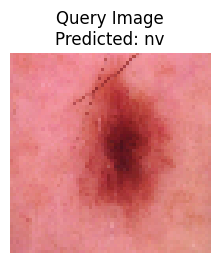

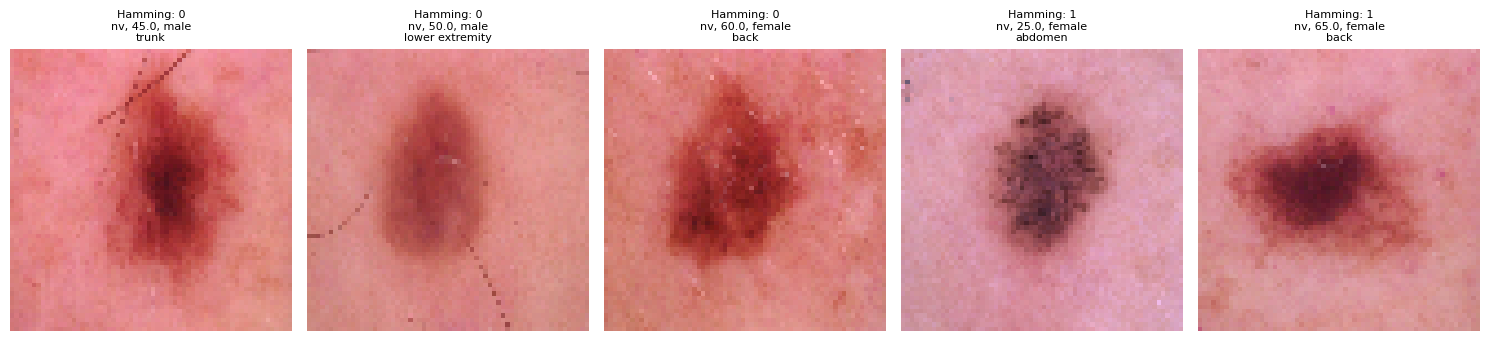

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image

def hamming_distance(a, b):
    return np.sum(a != b)

# Load hashes and filenames
db_hashes = np.load("hash_codes_binary.npy")
db_filenames = np.load("filenames.npy", allow_pickle=True)

# Load metadata
metadata_df = pd.read_csv("HAM10000_metadata.csv")

# Create a mapping from image_id to metadata row
metadata_df['image_id'] = metadata_df['image_id'].astype(str)
metadata_dict = metadata_df.set_index('image_id').to_dict(orient='index')

# Compute distances
distances = [hamming_distance(query_hash_binary[0], db_hash) for db_hash in db_hashes]
top_k_indices = np.argsort(distances)[:5]

# plotting the query image with the predicted class
plt.figure(figsize=(15, 9))
plt.subplot(2, 5, 1)
plt.imshow(query_img)
plt.title(f"Query Image\nPredicted: {predicted_class_name}")
plt.axis('off')

retrieved_classes = []

# Plot top 5 matches with metadata
plt.figure(figsize=(15, 6))
for i, idx in enumerate(top_k_indices):
    filepath = db_filenames[idx]
    img_id = os.path.splitext(os.path.basename(filepath))[0]  # get ID without extension

    img = image.load_img(filepath, target_size=(64, 64))
    plt.subplot(1, 5, i+1)
    plt.imshow(img)

    # Get metadata
    meta = metadata_dict.get(img_id, {})
    dx = meta.get('dx', 'N/A')
    age = meta.get('age', 'N/A')
    sex = meta.get('sex', 'N/A')
    loc = meta.get('localization', 'N/A')

    retrieved_classes.append(dx)

    title_text = f"Hamming: {distances[idx]}\n{dx}, {age}, {sex}\n{loc}"
    plt.title(title_text, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
print("Feature Vector Shape for Query:", query_feat.shape)
print("Example Feature Vector:", query_feat[0])


Feature Vector Shape for Query: (1, 32)
Example Feature Vector: [ 8.1361443e-01  5.1655724e+01  3.4601629e-02 -4.8235714e+01
 -1.5704143e+01 -3.8630552e+00 -8.4292984e+00  2.3947395e+01
  1.5989520e+01  3.0184336e+01 -1.1881158e+01 -1.4203568e+01
  1.1220269e+01 -1.3326437e+01  6.7015181e+00 -1.4887355e+01
 -7.3686376e+00 -7.6393600e+00 -4.2196507e+01 -1.1482977e+00
 -2.5049946e+01  7.3763794e-01 -2.6156126e+01 -1.2187930e+01
 -2.8907959e+01 -3.0366945e+00  1.5797501e+01  4.8939987e+01
 -4.0041740e+01  1.0417577e+01 -1.9958370e+01 -6.2251329e-01]


In [ ]:
print("Query Binary Hash Code:")
print(query_hash[0])

Query Binary Hash Code:
[1 1 1 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0]


<ipython-input-38-4fa1509dc67b>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_k_labels, y=top_k_distances, palette="Blues_d")


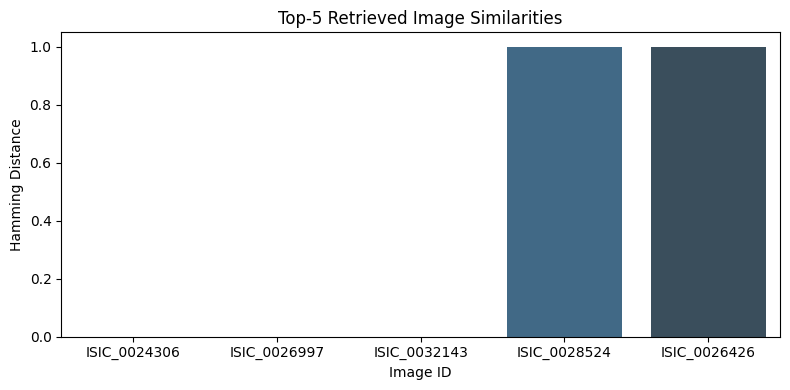

In [ ]:
import seaborn as sns

# Create data for chart
top_k_distances = [distances[idx] for idx in top_k_indices]
top_k_labels = [os.path.splitext(os.path.basename(db_filenames[idx]))[0] for idx in top_k_indices]

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x=top_k_labels, y=top_k_distances, palette="Blues_d")
plt.xlabel("Image ID")
plt.ylabel("Hamming Distance")
plt.title("Top-5 Retrieved Image Similarities")
plt.tight_layout()
plt.savefig("hamming_distance_chart.png", dpi=300)
plt.show()


<ipython-input-43-20a808aa640a>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sex_counts.index, y=sex_counts.values, palette='Set2')
<ipython-input-43-20a808aa640a>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=loc_counts.index, y=loc_counts.values, palette='flare')


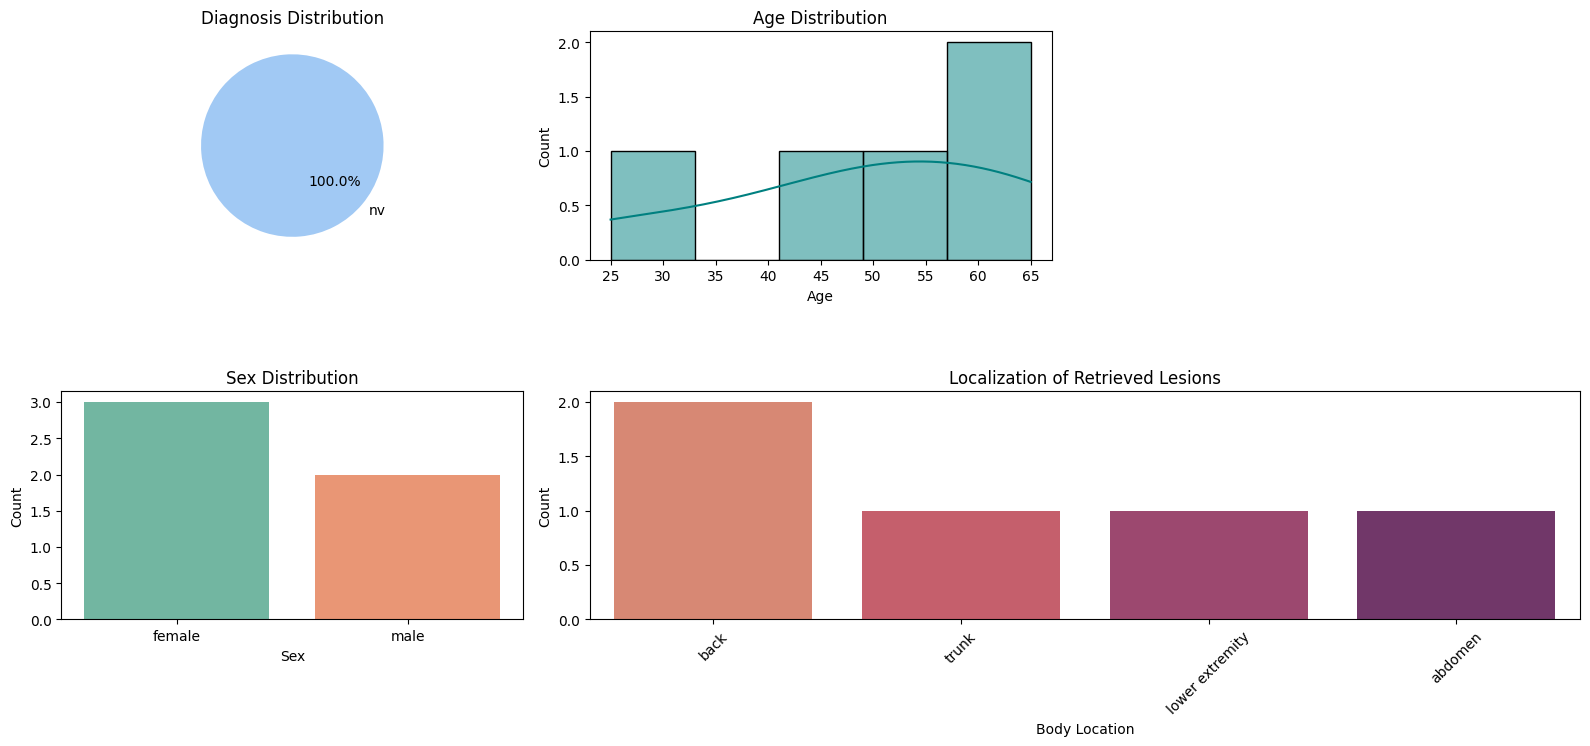

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from matplotlib.gridspec import GridSpec

# Collect data for top_k retrieved images
top_k_diagnoses = []
top_k_ages = []
top_k_sex = []
top_k_loc = []
top_k_labels = []
top_k_distances = []

for i in top_k_indices:
    file = db_filenames[i]
    img_id = os.path.splitext(os.path.basename(file))[0]
    meta = metadata_dict.get(img_id, {})

    top_k_labels.append(img_id)
    top_k_distances.append(distances[i])
    top_k_diagnoses.append(meta.get('dx', 'N/A'))
    age = meta.get('age')
    if not pd.isna(age):
        top_k_ages.append(age)
    top_k_sex.append(meta.get('sex', 'N/A'))
    top_k_loc.append(meta.get('localization', 'N/A'))

# Count values
dx_counts = pd.Series(top_k_diagnoses).value_counts()
sex_counts = pd.Series(top_k_sex).value_counts()
loc_counts = pd.Series(top_k_loc).value_counts()

# Setup grid
plt.figure(figsize=(16, 10))
gs = GridSpec(3, 3)

# Plot 2: Diagnosis Pie Chart
plt.subplot(gs[0, 0])
plt.pie(dx_counts, labels=dx_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title('Diagnosis Distribution')

# Plot 3: Age Histogram
plt.subplot(gs[0, 1])
sns.histplot(top_k_ages, bins=5, kde=True, color='teal')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

# Plot 4: Sex Bar Plot
plt.subplot(gs[1, 0])
sns.barplot(x=sex_counts.index, y=sex_counts.values, palette='Set2')
plt.title('Sex Distribution')
plt.ylabel('Count')
plt.xlabel('Sex')

# Plot 5: Localization Bar Plot
plt.subplot(gs[1, 1:])
sns.barplot(x=loc_counts.index, y=loc_counts.values, palette='flare')
plt.title('Localization of Retrieved Lesions')
plt.ylabel('Count')
plt.xlabel('Body Location')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



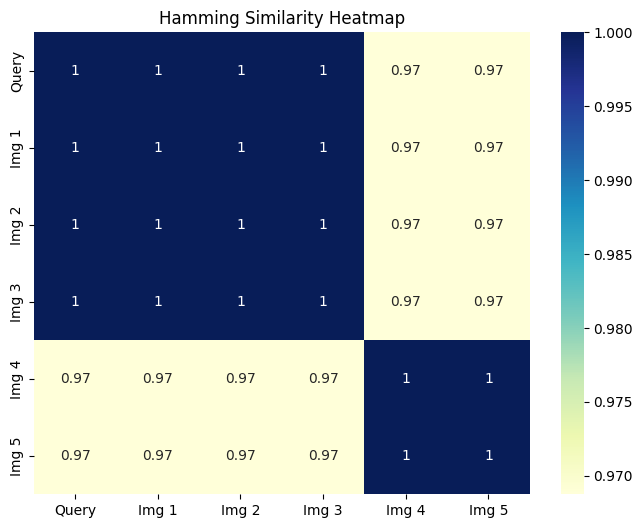

In [ ]:
import seaborn as sns

# Create a matrix: top_k + query
hash_matrix = [query_hash_binary[0]] + [db_hashes[i] for i in top_k_indices]
labels = ['Query'] + [f'Img {i+1}' for i in range(len(top_k_indices))]

# Compute Hamming similarity (1 - normalized distance)
similarity_matrix = np.zeros((len(hash_matrix), len(hash_matrix)))
for i in range(len(hash_matrix)):
    for j in range(len(hash_matrix)):
        similarity_matrix[i, j] = 1 - (np.sum(hash_matrix[i] != hash_matrix[j]) / len(hash_matrix[0]))

plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, xticklabels=labels, yticklabels=labels, cmap='YlGnBu')
plt.title("Hamming Similarity Heatmap")
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_single_query(query_hash, query_label, db_hashes, db_labels, k=5):
    def hamming_distance(a, b):
        return np.sum(a != b)

    # Compute distances and sort
    distances = [hamming_distance(query_hash[0], db_hash) for db_hash in db_hashes]
    top_k_indices = np.argsort(distances)[:k]
    top_k_labels = [db_labels[i] for i in top_k_indices]

    # Ground truth relevance: 1 if label matches, else 0
    y_true = [1 if label == query_label else 0 for label in top_k_labels]
    y_pred = [1]*k  # since we retrieved these as predictions

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    accuracy = np.mean(np.array(y_true) == np.array(y_pred))

    # Hit@k = was correct label found in top-k?
    hit_at_k = int(query_label in top_k_labels)

    # AP (Average Precision) for this query
    cum_precision = 0
    relevant_count = 0
    for i, label in enumerate(top_k_labels):
        if label == query_label:
            relevant_count += 1
            cum_precision += relevant_count / (i+1)
    average_precision = cum_precision / (relevant_count or 1)

    return {
        "Precision@k": precision,
        "Recall@k": recall,
        "F1@k": f1,
        "Accuracy@k": accuracy,
        "Hit@k": hit_at_k,
        "AP": average_precision,
        "Top_k_labels": top_k_labels
    }
# Assuming the metadata contains a column 'dx' that represents the labels for your images
db_labels = metadata_df['dx'].values  # or any other column that represents the label


In [ ]:
results = evaluate_single_query(query_hash_binary, predicted_class_name, db_hashes, db_labels, k=5)

for metric, value in results.items():
    if metric != "Top_k_labels":
        print(f"{metric}: {value:.4f}")


Precision@k: 0.8000
Recall@k: 1.0000
F1@k: 0.8889
Accuracy@k: 0.8000
Hit@k: 1.0000
AP: 0.8042
